In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from glob import glob
import sys

import util_tr_new as tr
from scipy import interpolate  # , signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

datadir = Path("/Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/231212_#1-1388(1-1)")
sample = "1388"
if not os.path.exists(datadir / sample):
    os.mkdir(datadir / sample)
savedir = datadir / sample

current_float = 50e-6
thickness = 2e-8  # m = 20 nm
width = 2e-5  # m = 20 um
e = 1.602e-19  # C
B_Rxx2omega, thresh_Rxx2omega = 0.1, 0.1
B_gamma, thresh_gamma = 0.1, 0.1


# RT

current=  5e-05


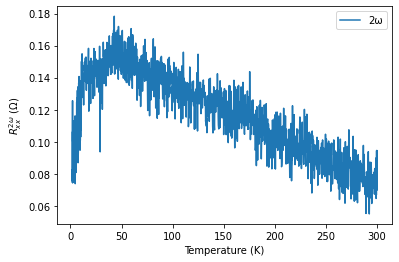

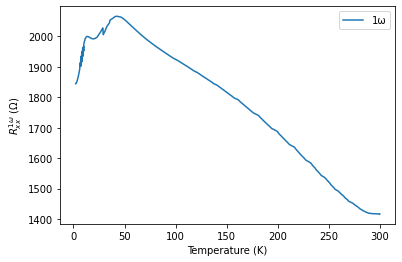

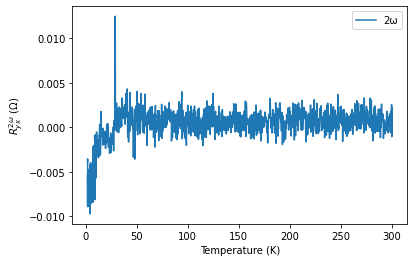

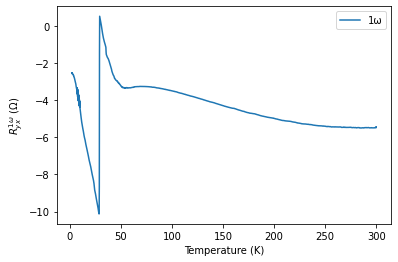

RT.csv saved


In [16]:
# RT
df_dict = {}
# for filename in sorted(glob(str(datadir / "3_14T_sweep_*e-*A.txt"))):
filename = str(datadir / "1_RT.txt")
key = Path(filename).stem

with open(filename, "r") as f:
    df = []
    i = 0
    while True:
        line = f.readline()
        if not line:
            break
        elif i == 0:
            header = line.split("\t")
        else:
            df.append([float(x) for x in line.split("\t")])
        i += 1
df = pd.DataFrame(df, columns=header)
# df_dict[Path(filename).stem] = df
df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)", "Lock-in3(X)", "Lock-in3(Y)", "Lock-in4(X)", "Lock-in4(Y)"]]
df.to_csv(savedir / ("raw_RT.csv"), index=False)

B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
# fixed_temp = df["Temperature (K)"].mean()
temp = df["Temperature (K)"].values
Vxx2omega_raw = df["Lock-in2(Y)"].values
Vxx1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
Vyx2omega_raw = df["Lock-in4(Y)"].values
Vyx1omega_raw = -df["Lock-in3(X)"].values  # 位相180°回転に注意


print("current= ", current_float)
Rxx2omega = Vxx2omega_raw / current_float
Rxx1omega = Vxx1omega_raw / current_float
Ryx2omega = Vyx2omega_raw / current_float
Ryx1omega = Vyx1omega_raw / current_float

current = np.full_like(temp, current_float)
plt.plot(temp, Rxx2omega, label="2ω")
plt.xlabel("Temperature (K)")
plt.ylabel(r"$R_{xx}^{2ω}$ (Ω)")
plt.legend()
plt.show()
plt.plot(temp, Rxx1omega, label="1ω")
plt.xlabel("Temperature (K)")
plt.ylabel(r"$R_{xx}^{1ω}$ (Ω)")
plt.legend()
plt.show()
plt.plot(temp, Ryx2omega, label="2ω")
plt.xlabel("Temperature (K)")
plt.ylabel(r"$R_{yx}^{2ω}$ (Ω)")
plt.legend()
plt.show()
plt.plot(temp, Ryx1omega, label="1ω")
plt.xlabel("Temperature (K)")
plt.ylabel(r"$R_{yx}^{1ω}$ (Ω)")
plt.legend()
plt.show()


Gxx1omega = savgol_filter(current_float / Vxx1omega_raw,  21, 3) # Ω^-1
Gxx2omega = savgol_filter(-2*Vxx2omega_raw / (Vxx1omega_raw)**2,  21, 3) # （ΩA)^-1

new_df = pd.DataFrame({
    "temp": temp, "current": current, "B": B_raw, 
    "Vxx2omega": Vxx2omega_raw, "Vxx1omega": Vxx1omega_raw,
    "Gxx2omega": Gxx2omega, "Gxx1omega": Gxx1omega,
    "Rxx2omega": Rxx2omega, "Rxx1omega": Rxx1omega})
new_df.to_csv(savedir / "RT.csv", index=False)
print("RT" + ".csv saved")

# 1 T @ 0deg 90deg

1_1T_sweep_50uA_2K_0deg
1_1T_sweep_50uA_2K_90deg
------------------1_1T_sweep_50uA_2K_0deg------------------


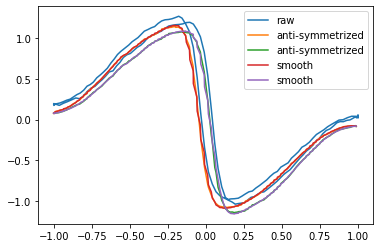

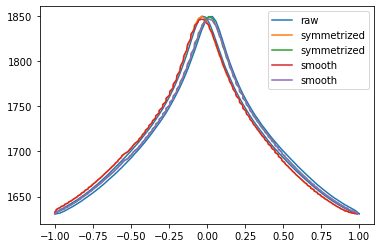

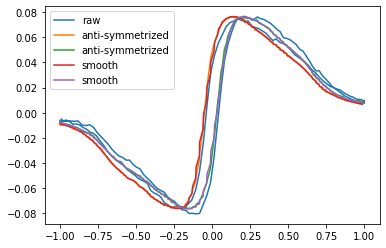

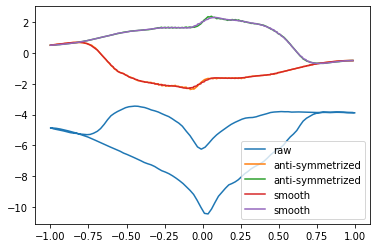

(array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]),)
R0 =  1846.1441468110102 , B =  -0.0334782
gamma =  -2.193408349845927e-11


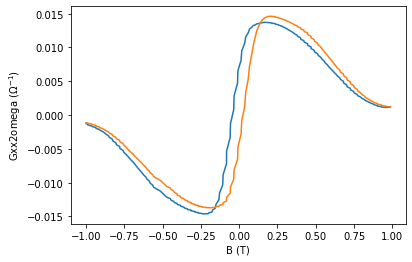

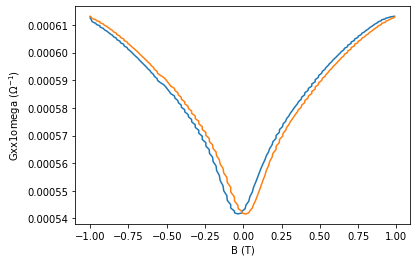

1_1T_sweep_50uA_2K_0deg.csv saved
------------------1_1T_sweep_50uA_2K_90deg------------------


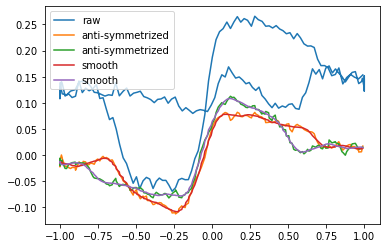

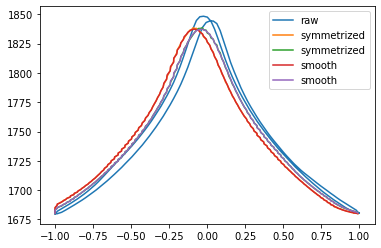

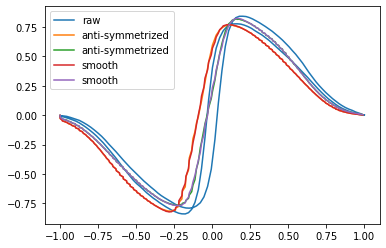

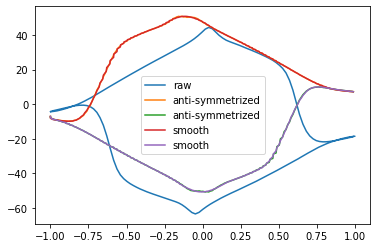

(array([72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]),)
R0 =  1837.2051888812819 , B =  -0.0782794
gamma =  1.6423778538032162e-12


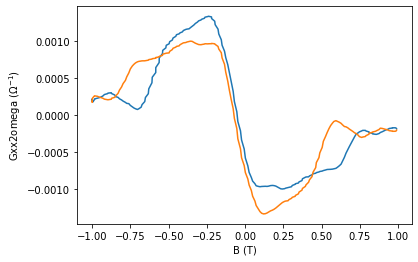

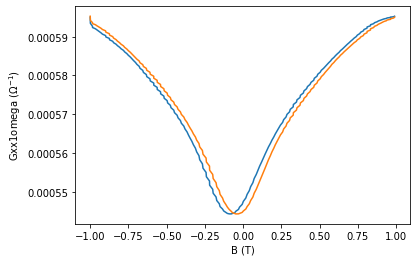

1_1T_sweep_50uA_2K_90deg.csv saved
2
2
2
2
[2.00011153 2.00113697]
[5.e-05 5.e-05]
[ 1.64237785e-12 -2.19340835e-11]
[1837.20518888 1846.14414681]


In [20]:
df_gamma_name = f"gamma_{B_gamma}T_50uA_20um_T_dep.csv"

# temp_dep
df_dict = {}
for filename in sorted(glob(str(datadir / "1_1T_sweep_50uA_2K_*deg.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key in df_dict.keys():
    print(f"------------------{key}------------------")
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)", "Lock-in3(X)", "Lock-in3(Y)", "Lock-in4(X)", "Lock-in4(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    Vxx2omega_raw = df["Lock-in2(Y)"].values
    # V1omega_raw = df["Lock-in1(Y)"].values
    Vxx1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
    Vyx2omega_raw = df["Lock-in4(Y)"].values
    Vyx1omega_raw = -df["Lock-in3(X)"].values  # 位相180°回転に注意
    B_ref_u, _, Vxx2omega_u, B_ref_d, _, Vxx2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx2omega_raw))  # 反対称化
    B_ref_u, Vxx1omega_u, _, B_ref_d, Vxx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx1omega_raw))  # 対称化
    B_ref_u, _, Vyx2omega_u, B_ref_d, _, Vyx2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vyx2omega_raw))  # 反対称化
    # B_ref_u, Vyx1omega_u, _, B_ref_d, Vyx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vyx1omega_raw))
    B_ref_u, _, Vyx1omega_u, B_ref_d, _, Vyx1omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vyx1omega_raw))  # 反対称化
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    Rxx2omega_u = Vxx2omega_u / current_float
    Rxx2omega_d = Vxx2omega_d / current_float
    Rxx1omega_u = Vxx1omega_u / current_float
    Rxx1omega_d = Vxx1omega_d / current_float
    Ryx2omega_u = Vyx2omega_u / current_float
    Ryx2omega_d = Vyx2omega_d / current_float
    Ryx1omega_u = Vyx1omega_u / current_float
    Ryx1omega_d = Vyx1omega_d / current_float

    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)
    Ryx2omega_d_smooth = savgol_filter(Ryx2omega_d, 21, 3)
    Ryx2omega_u_smooth = savgol_filter(Ryx2omega_u, 21, 3)
    Ryx1omega_d_smooth = savgol_filter(Ryx1omega_d, 21, 3)
    Ryx1omega_u_smooth = savgol_filter(Ryx1omega_u, 21, 3)

    plt.plot(B_raw, Vxx2omega_raw / current_float, label="raw")
    plt.plot(B_ref_d, Rxx2omega_d, label="anti-symmetrized")
    plt.plot(B_ref_u, Rxx2omega_u, label="anti-symmetrized")
    plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
    plt.plot(B_ref_u, Rxx2omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_raw, Vxx1omega_raw / current_float, label="raw")
    plt.plot(B_ref_d, Rxx1omega_u, label="symmetrized")
    plt.plot(B_ref_u, Rxx1omega_d, label="symmetrized")
    plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
    plt.plot(B_ref_u, Rxx1omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_raw, Vyx2omega_raw / current_float, label="raw")
    plt.plot(B_ref_d, Ryx2omega_d, label="anti-symmetrized")
    plt.plot(B_ref_u, Ryx2omega_u, label="anti-symmetrized")
    plt.plot(B_ref_d, Ryx2omega_d_smooth, label="smooth")
    plt.plot(B_ref_u, Ryx2omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_raw, Vyx1omega_raw / current_float, label="raw")
    plt.plot(B_ref_d, Ryx1omega_u, label="anti-symmetrized")
    plt.plot(B_ref_u, Ryx1omega_d, label="anti-symmetrized")
    plt.plot(B_ref_d, Ryx1omega_u_smooth, label="smooth")
    plt.plot(B_ref_u, Ryx1omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()

    current = np.full_like(B_ref_u, current_float)


    print(np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma))
    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
    DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]
    current_density = current_float / (width * thickness)  # A/m^2
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

    gamma = 2*(DeltaR / DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)
    currents.append(current_float)

    Gxx1omega_d = savgol_filter(current_float / Vxx1omega_d,  21, 3)
    Gxx1omega_u = savgol_filter(current_float / Vxx1omega_u,  21, 3)
    Gxx2omega_d = savgol_filter(-2*Vxx2omega_d / (Vxx1omega_d)**2,  21, 3)
    Gxx2omega_u = savgol_filter(-2*Vxx2omega_u / (Vxx1omega_u)**2,  21, 3)
    plt.plot(B_ref_d, Gxx2omega_d)
    plt.plot(B_ref_u, Gxx2omega_u)
    plt.xlabel("B (T)")
    plt.ylabel(r"Gxx2omega ($\Omega^{-1}$)")
    plt.show()
    plt.plot(B_ref_d, Gxx1omega_d)
    plt.plot(B_ref_u, Gxx1omega_u)
    plt.xlabel("B (T)")
    plt.ylabel(r"Gxx1omega ($\Omega^{-1}$)")
    plt.show()


    Rxx2omega_d_over_R0_B = 2*Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = 2*Rxx2omega_u_smooth / (R0 * current_density)

    new_df = pd.DataFrame({
        "temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, 
        "V2omega_u": Vxx2omega_u, "V2omega_d": Vxx2omega_d, "V1omega_d": Vxx1omega_d, "V1omega_u": Vxx1omega_u, 
        "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, 
        "Gxx2omega_u": Gxx2omega_u, "Gxx2omega_d": Gxx2omega_d, "Gxx1omega_u": Gxx1omega_u, "Gxx1omega_d": Gxx1omega_d,
        "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})
    new_df.to_csv(savedir / (key + ".csv"), index=False)
    print(key + ".csv saved")


sort_idx = np.argsort(np.array(temps))
currents_gamma, temps_gamma, gammas_gamma, R0s_gamma = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(gammas)[sort_idx], np.array(R0s)[sort_idx]
print(temps_gamma)
df_gamma = pd.DataFrame({"current": currents_gamma, "temp": temps_gamma, "gamma": gammas_gamma, "R0": R0s_gamma})
df_gamma.to_csv(savedir / df_gamma_name, index=False)

# 角度依存性

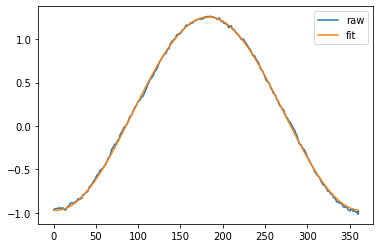

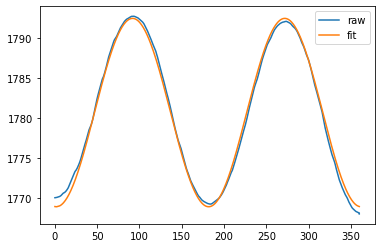

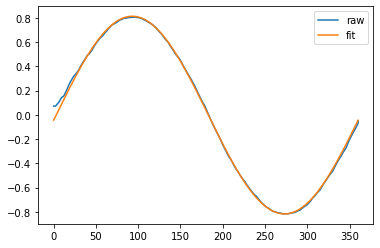

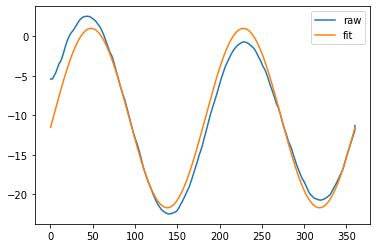

1_theta_dep_0.2T_2K.csv saved


In [22]:


filename = str(datadir / "1_theta_dep_0.2T_2K.txt")
key = Path(filename).stem
with open(filename, "r") as f:
    df = []
    i = 0
    while True:
        line = f.readline()
        if not line:
            break
        elif i == 0:
            header = line.split("\t")
        else:
            df.append([float(x) for x in line.split("\t")])
        i += 1
df = pd.DataFrame(df, columns=header)


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []


df = df[["Temperature (K)", "Field (Oe)", "Position (deg)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)", "Lock-in3(X)", "Lock-in3(Y)", "Lock-in4(X)", "Lock-in4(Y)"]]
df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

position_raw = df["Position (deg)"].values
# B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
fixed_B = df["Field (Oe)"].mean() * 1e-4  # Oe -> T
fixed_temp = df["Temperature (K)"].mean()
temps.append(fixed_temp)

Vxx2omega_raw = df["Lock-in2(Y)"].values
# V1omega_raw = df["Lock-in1(Y)"].values
Vxx1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
Vyx2omega_raw = df["Lock-in4(Y)"].values
Vyx1omega_raw = -df["Lock-in3(X)"].values  # 位相180°回転に注意

Rxx2omega = Vxx2omega_raw / current_float
Rxx1omega = Vxx1omega_raw / current_float
Ryx2omega = Vyx2omega_raw / current_float
Ryx1omega = Vyx1omega_raw / current_float


def func_T1(x, a, b, c):
    return a * np.cos(np.radians(x) + b) + c


def func_T2(x, a, b, c):
    return a * np.cos(2 * np.radians(x) + b) + c


param_d, cov_d = curve_fit(func_T1, position_raw, Rxx2omega)
Rxx2omega_fit = func_T1(position_raw, *param_d)
# AMR = rho(θ) - rho(0) / rho(0)
AMRxx2omega = (Rxx2omega_fit - func_T1(0, *param_d)) / func_T1(0, *param_d)
param_u, cov_u = curve_fit(func_T2, position_raw, Rxx1omega)
Rxx1omega_fit = func_T2(position_raw, *param_u)
AMRxx1omega = (Rxx1omega_fit - func_T2(0, *param_u)) / func_T2(0, *param_u)
param_d, cov_d = curve_fit(func_T1, position_raw, Ryx2omega)
Ryx2omega_fit = func_T1(position_raw, *param_d)
AMRyx2omega = (Ryx2omega_fit - func_T1(0, *param_d)) / func_T1(0, *param_d)
param_u, cov_u = curve_fit(func_T2, position_raw, Ryx1omega)
Ryx1omega_fit = func_T2(position_raw, *param_u)
AMRyx1omega = (Ryx1omega_fit - func_T2(0, *param_u)) / func_T2(0, *param_u)


plt.plot(position_raw, Rxx2omega, label="raw")
plt.plot(position_raw, Rxx2omega_fit, label="fit")
plt.legend()
plt.show()
plt.plot(position_raw, Vxx1omega_raw / current_float, label="raw")
plt.plot(position_raw, Rxx1omega_fit, label="fit")
plt.legend()
plt.show()
plt.plot(position_raw, Vyx2omega_raw / current_float, label="raw")
plt.plot(position_raw, Ryx2omega_fit, label="fit")
plt.legend()
plt.show()
plt.plot(position_raw, Vyx1omega_raw / current_float, label="raw")
plt.plot(position_raw, Ryx1omega_fit, label="fit")
plt.legend()
plt.show()

temp = np.full_like(position_raw, fixed_temp)
current = np.full_like(position_raw, current_float)

new_df = pd.DataFrame(
    {
        "temp": temp,
        "current": current,
        "position": position_raw,
        "Rxx2omega": Rxx2omega_fit,
        "Rxx1omega": Rxx1omega_fit,
        "Ryx2omega": Ryx2omega_fit,
        "Ryx1omega": Ryx1omega_fit,
        "Gxx2omega": -2*Vxx2omega_raw / (Vxx1omega_raw)**2,
        "Gxx1omega": current_float / Vxx1omega_raw,
        "AMRxx2omega": AMRxx2omega,
        "AMRxx1omega": AMRxx1omega,
        "AMRyx2omega": AMRyx2omega,
        "AMRyx1omega": AMRyx1omega,
    }
)
new_df.to_csv(savedir / (key + ".csv"), index=False)
print(key + ".csv saved")
# sys.exit()

# temp_dep (0deg)

In [26]:

df_gamma_name = f"gamma_{B_gamma}T_50uA_20um_T_dep.csv"
# temp_dep
df_dict = {}
for filename in sorted(glob(str(datadir / "*_9T_sweep_50uA_*K_0deg.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key in df_dict.keys():
    print(f"------------------{key}------------------")
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)", "Lock-in3(X)", "Lock-in3(Y)", "Lock-in4(X)", "Lock-in4(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    Vxx2omega_raw = df["Lock-in2(Y)"].values
    # V1omega_raw = df["Lock-in1(Y)"].values
    Vxx1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
    Vyx2omega_raw = df["Lock-in4(Y)"].values
    Vyx1omega_raw = -df["Lock-in3(X)"].values  # 位相180°回転に注意
    B_ref_u, _, Vxx2omega_u, B_ref_d, _, Vxx2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx2omega_raw))  # 反対称化
    B_ref_u, Vxx1omega_u, _, B_ref_d, Vxx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx1omega_raw))  # 対称化
    B_ref_u, _, Vyx2omega_u, B_ref_d, _, Vyx2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vyx2omega_raw))  # 反対称化
    # B_ref_u, Vyx1omega_u, _, B_ref_d, Vyx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vyx1omega_raw))
    B_ref_u, Vyx1omega_u, _, B_ref_d, Vyx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vyx1omega_raw))  # 対称化
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    Rxx2omega_u = Vxx2omega_u / current_float
    Rxx2omega_d = Vxx2omega_d / current_float
    Rxx1omega_u = Vxx1omega_u / current_float
    Rxx1omega_d = Vxx1omega_d / current_float
    Ryx2omega_u = Vyx2omega_u / current_float
    Ryx2omega_d = Vyx2omega_d / current_float
    Ryx1omega_u = Vyx1omega_u / current_float
    Ryx1omega_d = Vyx1omega_d / current_float

    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)
    Ryx2omega_d_smooth = savgol_filter(Ryx2omega_d, 21, 3)
    Ryx2omega_u_smooth = savgol_filter(Ryx2omega_u, 21, 3)
    Ryx1omega_d_smooth = savgol_filter(Ryx1omega_d, 21, 3)
    Ryx1omega_u_smooth = savgol_filter(Ryx1omega_u, 21, 3)

    current = np.full_like(B_ref_u, current_float)

    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
    DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]

    current_density = current_float / (width * thickness)  # A/m^2
    # print("current_density = ", current_density)
    # R0 = 0.041106 / current_float  # Ω
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

    gamma = 2*(DeltaR / DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)
    currents.append(current_float)

    Gxx1omega_d = savgol_filter(current_float / Vxx1omega_d,  21, 3)
    Gxx1omega_u = savgol_filter(current_float / Vxx1omega_u,  21, 3)
    Gxx2omega_d = savgol_filter(-2*Vxx2omega_d / (Vxx1omega_d)**2,  21, 3)
    Gxx2omega_u = savgol_filter(-2*Vxx2omega_u / (Vxx1omega_u)**2,  21, 3)

    Rxx2omega_d_over_R0_B = 2*Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = 2*Rxx2omega_u_smooth / (R0 * current_density)


    new_df = pd.DataFrame({
        "temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, 
        "Vxx2omega_u": Vxx2omega_u, "Vxx2omega_d": Vxx2omega_d, "Vxx1omega_d": Vxx1omega_d, "Vxx1omega_u": Vxx1omega_u, 
        "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, 
        "Gxx2omega_u": Gxx2omega_u, "Gxx2omega_d": Gxx2omega_d, "Gxx1omega_u": Gxx1omega_u, "Gxx1omega_d": Gxx1omega_d,
        "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})
    new_df.to_csv(savedir / (key + ".csv"), index=False)
    print(key + ".csv saved")


sort_idx = np.argsort(np.array(temps))
currents_gamma, temps_gamma, gammas_gamma, R0s_gamma = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(gammas)[sort_idx], np.array(R0s)[sort_idx]
print(temps)
df_gamma = pd.DataFrame({"current": currents_gamma, "temp": temps_gamma, "gamma": gammas_gamma, "R0": R0s_gamma})
df_gamma.to_csv(savedir / df_gamma_name, index=False)

1_9T_sweep_50uA_10K_0deg
1_9T_sweep_50uA_12K_0deg
1_9T_sweep_50uA_14K_0deg
1_9T_sweep_50uA_16K_0deg
1_9T_sweep_50uA_18K_0deg
1_9T_sweep_50uA_20K_0deg
1_9T_sweep_50uA_25K_0deg
1_9T_sweep_50uA_2K_0deg
1_9T_sweep_50uA_30K_0deg
1_9T_sweep_50uA_4K_0deg
1_9T_sweep_50uA_6K_0deg
2_9T_sweep_50uA_40K_0deg
2_9T_sweep_50uA_50K_0deg
------------------1_9T_sweep_50uA_10K_0deg------------------
R0 =  1955.784040922745 , B =  -0.028997500000000002
gamma =  -1.1833203535412698e-11
1_9T_sweep_50uA_10K_0deg.csv saved
------------------1_9T_sweep_50uA_12K_0deg------------------
R0 =  1974.7439555207875 , B =  -0.062108100000000006
gamma =  -5.26442211610782e-12
1_9T_sweep_50uA_12K_0deg.csv saved
------------------1_9T_sweep_50uA_14K_0deg------------------
R0 =  1994.8073061773835 , B =  0.00456653
gamma =  -7.90240203839437e-12
1_9T_sweep_50uA_14K_0deg.csv saved
------------------1_9T_sweep_50uA_16K_0deg------------------
R0 =  1996.9104975630219 , B =  -0.0388777
gamma =  -3.385805987140956e-12
1_9T_swee

In [5]:
current_float

5e-05

# TI

In [9]:

Delta = -3.3386e-12 - (3.021e-12)
DeltaB = 0.10922 - (-0.10097)
# R0 = 1842.2
# current_density = current_float / (width * thickness)  # A/m^2
gamma = (Delta / DeltaB)
gamma

-3.025643465436034e-11

In [15]:
current_float = 50e-6
width = 20e-6
thickness = 20e-9
R0 = 1849.1
current_density = current_float / (width * thickness)  # A/m^2

DeltaRxx2omega = -1.0516 - (0.98947)
DeltaB = 0.084272 - (-0.15608)
gamma = (DeltaRxx2omega / DeltaB) / (current_density * R0)
gamma

-3.6740050381355844e-11

# WSM

In [10]:

Delta = 2.1954e-12 - (-1.0595e-12)
DeltaB = 0.10176 - (-0.10367)
gamma = Delta / DeltaB
gamma

1.5844326534585992e-11

In [18]:
current_float = 50e-6
width = 20e-6
thickness = 20e-9
R0 = 979.13
current_density = current_float / (width * thickness)  # A/m^2

DeltaRxx2omega = 0.58196
DeltaB = 0.30773
gamma = (DeltaRxx2omega / DeltaB) / (current_density * R0)
gamma

1.5451581183735723e-11

# NI

In [11]:
Delta = -5.7619e-14 - (5.9832e-14)
DeltaB = 1.5544 - (-1.5064)
gamma = Delta / DeltaB
gamma

-3.837264767381077e-14

In [13]:
current_float = 250e-6
width = 100e-6
thickness = 20e-9
R0 = 644.56
current_density = current_float / (width * thickness)  # A/m^2

DeltaRxx2omega = -0.0033581 - (0.0036635)
DeltaB = 1.1107 - (-1.0011)
gamma = (DeltaRxx2omega / DeltaB) / (current_density * R0)
gamma

-4.126766877860007e-14